In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.afw.display as afwDisplay
import lsst.afw.table

from kuaizi.display import display_single
from astropy.io import fits
from astropy.table import Table, hstack

import sys
sys.path.append('/home/jiaxuanl/Research/Merian/lambo/scripts/')

In [2]:
def moments_to_shape(xx, xy, yy):
    '''
    Calculate the shape parameters from the quadrupole moments.
    Based on Song Huang's unagi code: 
    https://github.com/dr-guangtou/unagi/blob/66d6107f7d5118581e30040916f303c860a216e2/unagi/catalog.py#L60
    with significant modification. His definition for radius was wrong.
    
    Definition of the outputs
    -------------------------
    See https://arxiv.org/pdf/1203.6833.pdf, or http://doxygen.lsst.codes/stack/doxygen/x_mainDoxyDoc/classlsst_1_1pipe_1_1tasks_1_1functors_1_1_radius_from_quadrupole.html/
    
    Determinant radius: 4th root of the determinant of the quadrupole matrix.
        i.e., r_det = (xx * yy - xy**2)**(1/4)
    Trace radius: (0.5 * (xx + yy))**(1/2)
    Ellipticity: sqrt(e1**2 + e2**2)
    Axis ratio: sqrt((1 - ell) / (1 + ell)), where ell = sqrt(e1**2 + e2**2), and ell = (a**2 - b**2) / (a**2 + b**2).
    Position angle: -0.5 * arctan(e2 / e1).
    
    Parameters
    ----------
    xx, xy, yy: float. Quadrupole moments.
    
    Returns
    -------
    r_det: float. Determinant radius.
    r_trc: float. Trace radius.
    axis_ratio: float. Axis ratio b/a.
    theta: float. Position angle in degree.
    '''
    # Two elliptcities
    e1 = (xx - yy) / (xx + yy)
    e2 = (2.0 * xy / (xx + yy))

    # Get the r50 or determinant radius, defined as 
    # 4th root of the determinant of the quadrupole matrix.
    r_det = (xx * yy - xy**2)**(1/4)
    # we also compute trace radius, defined as (0.5 * (xx + yy))**(1/2)
    r_trc = (0.5 * (xx + yy))**(1/2)

    # Ellipticity or axis ratio
    ell = np.sqrt(e1 ** 2.0 + e2 ** 2.0)
    axis_ratio = np.sqrt((1 - ell) / (1 + ell)) # axis ratio

    # Position angle in degree or radian
    theta = (-0.5 * np.arctan2(e2, e1))
    theta = np.rad2deg(theta)
    
    return r_det, r_trc, axis_ratio, theta

def shape_to_ellipse(x, y, r, q, theta):
    """
    For display purpose, convert parameters to Matplotlib Ellipse patch.
    
    Parameters
    ----------
    x, y: float. Center of the ellipse.
    r: float. Determinant radius.
    q: float. Axis ratio b/a.
    theta: float. Position angle in degree.
    """
    from matplotlib.patches import Ellipse
    a = r / np.sqrt(q) * 2 # semi-major axis
    b = a * q
    
    ell = Ellipse(xy=(x, y),
                  width=a,
                  height=b,
                  angle=180-theta, 
                  facecolor='None')
    return ell

---

In [2]:
import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')

filt = 'N708'
# filt = 'N540'
tract = 9813
patch = 61
patch_old = f'{patch % 9},{patch // 9}'

dataId = dict(tract=tract, patch=patch, band=filt)

refCatObj = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

# refExposure = butler.get(
#     'deepCoadd_calexp',
#     collections='DECam/runs/merian/dr1_wide',
#     dataId=dataId,
#     instrument='DECam',
#     skymap='hsc_rings_v1',
# )

In [10]:
lsst.meas.base.ForcedPhotCoaddTask??

In [3]:
refCatObj.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['D'](name="base_SdssCentroid_x", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="base_SdssCentroid_y", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['F'](name="base_SdssCentroid_xErr", doc="1-sigma uncertainty on x position", units="pixel"), Key<F>(offset=56, nElements=1)),
    (Field['F'](name="base_SdssCentroid_yErr", doc="1-sigma uncertaint

In [4]:
cat = refCatObj['meas'][filt]

# Build a new catalog to store shapes
new_cat = Table(data=[cat.index.values], names=['id'])
new_cat['coord_ra'] = np.rad2deg(cat['coord_ra'].values)
new_cat['coord_dec'] = np.rad2deg(cat['coord_dec'].values)
new_cat['x'] = cat['base_SdssCentroid_x'].values
new_cat['y'] = cat['base_SdssCentroid_y'].values


# Different shapes
name = 'base_SdssShape'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_Sdss'] = r_det
new_cat[f'{filt}_q_Sdss'] = q
new_cat[f'{filt}_PA_Sdss'] = theta


name = 'modelfit_CModel_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel'] = r_det
new_cat[f'{filt}_q_CModel'] = q
new_cat[f'{filt}_PA_CModel'] = theta


name = 'modelfit_CModel_exp_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel_exp'] = r_det
new_cat[f'{filt}_q_CModel_exp'] = q
new_cat[f'{filt}_PA_CModel_exp'] = theta


name = 'modelfit_CModel_dev_ellipse'
r_det, r_trc, q, theta = moments_to_shape(cat[f'{name}_xx'].values, 
                                          cat[f'{name}_xy'].values, 
                                          cat[f'{name}_yy'].values)
new_cat[f'{filt}_Re_CModel_dev'] = r_det
new_cat[f'{filt}_q_CModel_dev'] = q
new_cat[f'{filt}_PA_CModel_dev'] = theta

### Visualize the shapes

In [11]:
# obj = new_cat[30961]
obj = new_cat[21992]
# obj = new_cat[26916]

(30766, 26422)


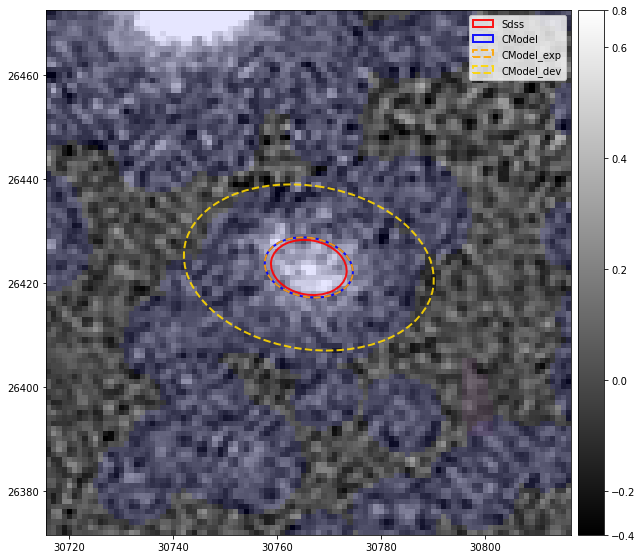

In [12]:
import lsst.geom as geom
import lsst.afw.display as afwDisplay

pix = geom.Point2I(obj['x'], obj['y'])
print(pix)
# Define a bounding box for the cutout region
bbox = geom.Box2I(pix, pix)
bbox.grow(50)

cutout = refExposure[bbox]

afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")

# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('NO_DATA', 'cyan')
# display.setMaskPlaneColor('DETECTED', 'blue')

display.setMaskTransparency(90)

display.mtv(cutout)

for c, name in zip(['r', 'b'], ['Sdss', 'CModel']):
    e = shape_to_ellipse(obj['x'], obj['y'], 
                         obj[f'{filt}_Re_{name}'], obj[f'{filt}_q_{name}'], obj[f'{filt}_PA_{name}'])
    ax.add_artist(e)
    e.set_alpha(0.9)
    e.set_facecolor('None')
    e.set_edgecolor(c)
    e.set_linewidth(2.0)
    e.set_label(name)
    
for c, name in zip(['orange', 'gold'], ['CModel_exp', 'CModel_dev']):
    e = shape_to_ellipse(obj['x'], obj['y'], 
                         obj[f'{filt}_Re_{name}'], obj[f'{filt}_q_{name}'], obj[f'{filt}_PA_{name}'])
    ax.add_artist(e)
    e.set_alpha(0.9)
    e.set_facecolor('None')
    e.set_edgecolor(c)
    e.set_linestyle('--')
    e.set_linewidth(2.0)
    e.set_label(name)

plt.legend()